# Upgrade pandas

In [1]:
! pip install --upgrade pip
! pip install --upgrade pandas
! pip install --upgrade sklearn

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: numpy>=1.9.0 in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: python-dateutil>=2 in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: pytz>=2011k in /opt/conda/lib/python3.6/site-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /opt/conda/lib/python3.6/site-packages (from python-dateutil>=2->pandas)
Requirement already up-to-date: sklearn in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (from sklearn)


# Load data

In [2]:
import os, pandas, json
from pandas.io.json import json_normalize

SNAPSHOT_PATH = os.path.join("production", "state", "snapshots.json")

def to_dataframe(file, snapshot_path=SNAPSHOT_PATH):
    dataframe = pandas.read_json(os.path.join(snapshot_path, file), lines=True)
    return json_normalize(json.loads(dataframe.to_json(orient='records')))
    
def load_snapshot_data(snapshot_path=SNAPSHOT_PATH):
    json_paths = os.listdir(snapshot_path)
    dataframes = [to_dataframe(file) for file in json_paths]
    
    return pandas.concat(dataframes)

In [3]:
snapshots = load_snapshot_data()
snapshots.head()

,drive.orientation,drive.throttle,imagePath,start,timeWindow,uuid,vehicle.backLeft.command.value,vehicle.backLeft.speed,vehicle.backRight.command.value,vehicle.backRight.speed,vehicle.frontLeft.command.value,vehicle.frontLeft.speed,vehicle.frontRight.command.value,vehicle.frontRight.speed
0,90,0,/dev/null,1522644265855,400,512318b4-c70d-4b9d-a3dc-9b4befcfa242,4,0,4,0,4,0,4,0
1,90,0,/home/miguel/IdeaProjects/RapBot/data/producti...,1522644280157,79,f0840909-2df1-4d0f-870b-111b971ae7e0,4,0,4,0,4,0,4,0
2,90,5,/home/miguel/IdeaProjects/RapBot/data/producti...,1522644281710,97,90b5f578-22bf-4872-ae27-7946f89eb6de,1,5,1,5,1,5,1,5
3,270,5,/home/miguel/IdeaProjects/RapBot/data/producti...,1522644282801,101,8938da82-5d2c-4cbf-a093-e2bbea3546d9,2,5,2,5,2,5,2,5
4,270,10,/home/miguel/IdeaProjects/RapBot/data/producti...,1522644283375,93,99e8ad93-816f-448a-9150-b8fcd87984d3,2,10,2,10,2,10,2,10


In [4]:
snapshots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 14 columns):
drive.orientation                   326 non-null int64
drive.throttle                      326 non-null int64
imagePath                           326 non-null object
start                               326 non-null int64
timeWindow                          326 non-null int64
uuid                                326 non-null object
vehicle.backLeft.command.value      326 non-null int64
vehicle.backLeft.speed              326 non-null int64
vehicle.backRight.command.value     326 non-null int64
vehicle.backRight.speed             326 non-null int64
vehicle.frontLeft.command.value     326 non-null int64
vehicle.frontLeft.speed             326 non-null int64
vehicle.frontRight.command.value    326 non-null int64
vehicle.frontRight.speed            326 non-null int64
dtypes: int64(12), object(2)
memory usage: 35.7+ KB


In [5]:
snapshots.describe()

,drive.orientation,drive.throttle,start,timeWindow,vehicle.backLeft.command.value,vehicle.backLeft.speed,vehicle.backRight.command.value,vehicle.backRight.speed,vehicle.frontLeft.command.value,vehicle.frontLeft.speed,vehicle.frontRight.command.value,vehicle.frontRight.speed
count,326.000000,326.000000,3.260000e+02,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,163.435583,167.561350,1.522644e+12,53.288344,1.490798,155.088957,1.490798,118.377301,1.490798,155.088957,1.490798,118.377301
std,130.040847,87.362838,2.519143e+04,34.413633,0.536290,93.665434,0.536290,65.487300,0.536290,93.665434,0.536290,65.487300
min,30.000000,0.000000,1.522644e+12,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,30.000000,90.000000,1.522644e+12,28.000000,1.000000,63.000000,1.000000,75.000000,1.000000,63.000000,1.000000,75.000000
50%,90.000000,180.000000,1.522644e+12,54.500000,1.000000,165.000000,1.000000,127.000000,1.000000,165.000000,1.000000,127.000000
75%,270.000000,255.000000,1.522644e+12,73.000000,2.000000,255.000000,2.000000,129.500000,2.000000,255.000000,2.000000,129.500000
max,330.000000,255.000000,1.522644e+12,400.000000,4.000000,255.000000,4.000000,255.000000,4.000000,255.000000,4.000000,255.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f605a089748>,
      dtype=object)

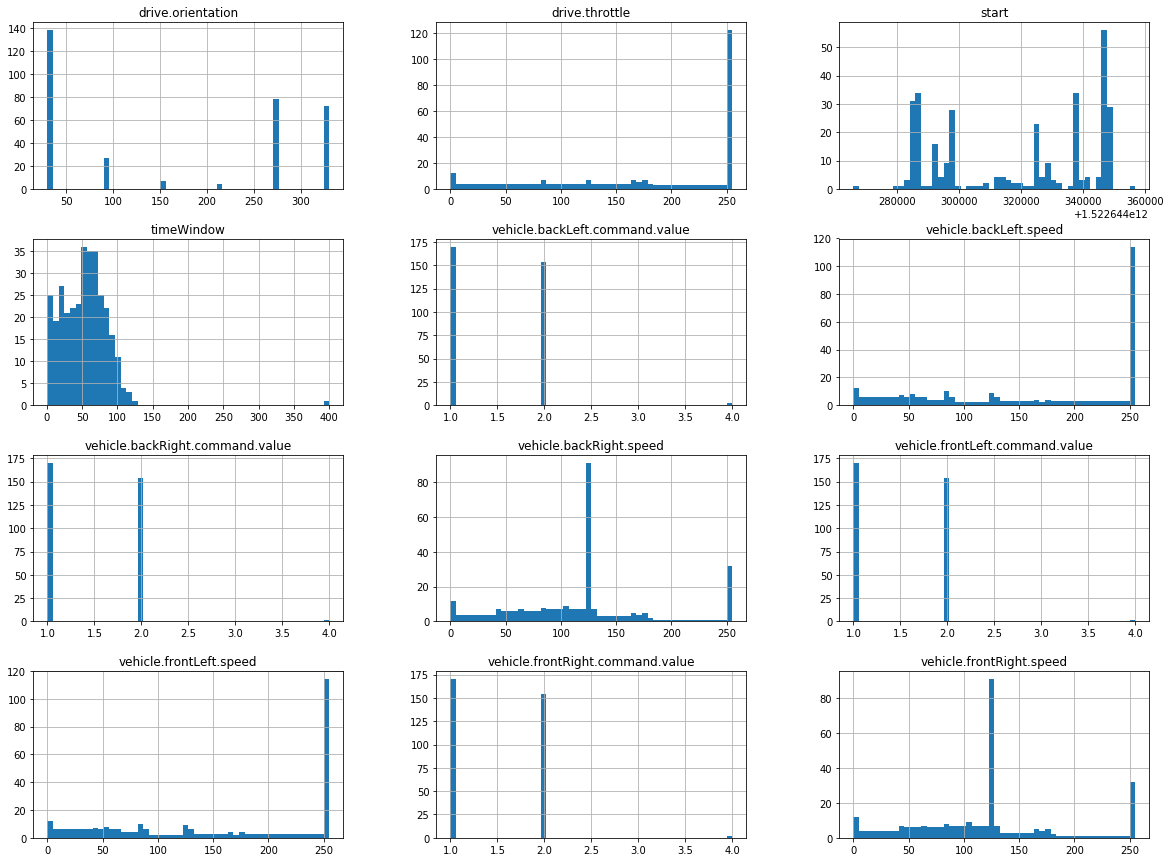

In [6]:
%matplotlib inline

snapshots.hist(bins=50, figsize=(20, 15))

# Split into train and test sets

In [7]:
import hashlib, numpy

def test_set_check(identifier, test_ratio, hash):
    return hash(identifier).digest()[-1] < (256 * test_ratio)

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_.encode(), test_ratio, hash))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [8]:
train_set, test_set = split_train_test_by_id(snapshots, 0.2, "uuid")
print(len(train_set), "train + ", len(test_set), "test")

263 train +  63 test


# Add turn direction